In [20]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.models as models
from tqdm import tqdm
import random
import numpy as np
import os
import torchao
from copy import deepcopy
import time
from torchao.quantization import (
    quantize_,
    Int8WeightOnlyConfig,
    Int4WeightOnlyConfig
)
from torchao.quantization.qat import QATConfig
from torchao.dtypes import Int4CPULayout
from torch import nn
import torchao
import matplotlib.pyplot as plt
from torchao.quantization import Int8DynamicActivationInt8WeightConfig

In [21]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_WORKERS = 0

In [22]:
def train_epoch(model, loader, criterion, optimizer, device):
  model.to(device)
  model.train()
  running_loss, correct, total = 0.0, 0, 0

  for inputs, labels in tqdm(loader):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    logits = model(inputs)              # forward pass
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(logits.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  avg_loss = running_loss / total
  accuracy = 100. * correct / total
  return avg_loss, accuracy


def evaluate(model, test_loader, device):
  model.eval()
  model.to(device)

  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in tqdm(test_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

In [23]:
def fix_random_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def get_model_size(model, path="/tmp/temp_model.pt"):
  """
  Save a PyTorch model temporarily and return its size in MB.

  Args:
      model: PyTorch model (nn.Module)
      path: Temporary file path to save the model

  Returns:
      Size of the model in MB (float)
  """
  torch.save(model, path)
  size_mb = os.path.getsize(path) / 1024 / 1024
  return size_mb

Fixed random seed: 42


In [24]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

g = torch.Generator()
g.manual_seed(42)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)
train_subset, val_subset = random_split(full_train, [45000, 5000], generator=g)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform
test_dataset.transform = test_transform

print("Training set size:", len(train_subset))
print("Validation set size:", len(val_subset))
print("Test set size:", len(test_dataset))

def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_subset, shuffle=True)
val_loader = get_loader(val_subset, shuffle=False)
test_loader = get_loader(test_dataset, shuffle=False)

Training set size: 45000
Validation set size: 5000
Test set size: 10000


In [25]:
model_base = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
model_base.classifier[6] = torch.nn.Linear(4096, 100)
model_base.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model_base = model_base.to(device)
model = deepcopy(model_base)
model.load_state_dict(torch.load("vgg11_cifar100_baseline_5e.pt", map_location=device))

<All keys matched successfully>

In [26]:
def collect_activations(model, data_loader, device, layer_names=None, num_batches=5):
    """
    Collect activation tensors from specified layers.
    """
    activations = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            out = output.detach().cpu().flatten()
            if name not in activations:
                activations[name] = []
            # store small random subset to avoid memory blow-up
            sample = out[torch.randperm(len(out))[:5000]]
            activations[name].append(sample)
        return hook
    
    # register hooks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU) or (layer_names and name in layer_names):
            hooks.append(module.register_forward_hook(hook_fn(name)))

    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(data_loader):
            inputs = inputs.to(device)
            model(inputs)
            if i >= num_batches:
                break

    # concatenate
    for name in activations:
        activations[name] = torch.cat(activations[name], dim=0)

    for h in hooks:
        h.remove()

    return activations

activations = collect_activations(model, test_loader, device)

In [27]:
print("Collected activation layer names:\n", list(activations.keys()))

Collected activation layer names:
 ['features.1', 'features.4', 'features.7', 'features.9', 'features.12', 'features.14', 'features.17', 'features.19', 'classifier.1', 'classifier.4']


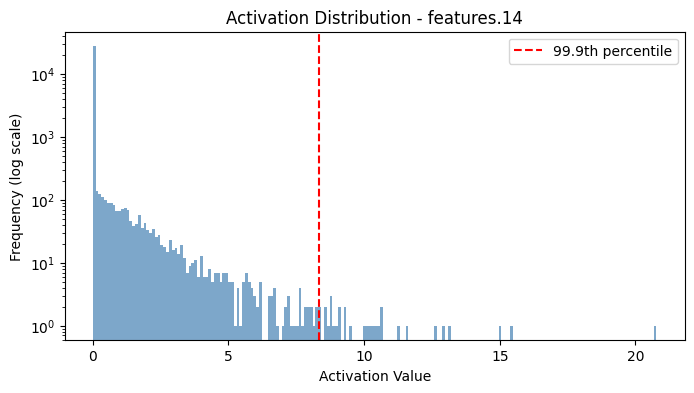

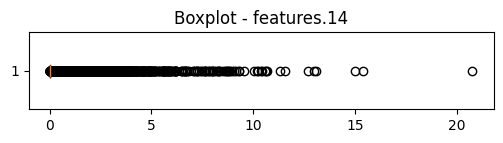

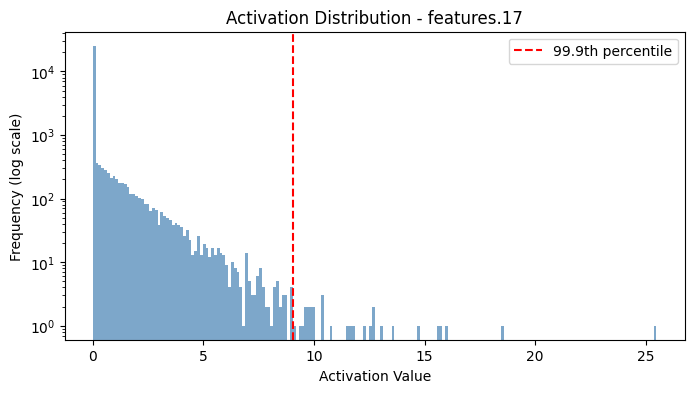

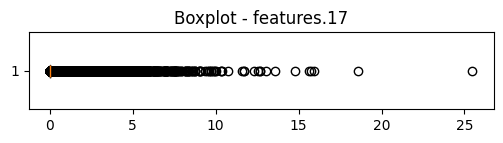

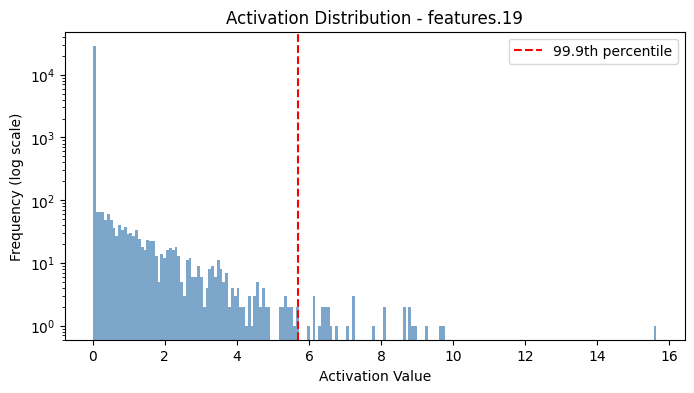

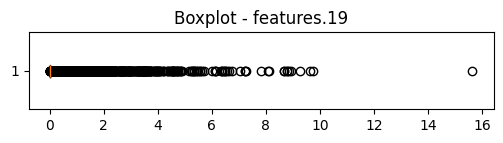

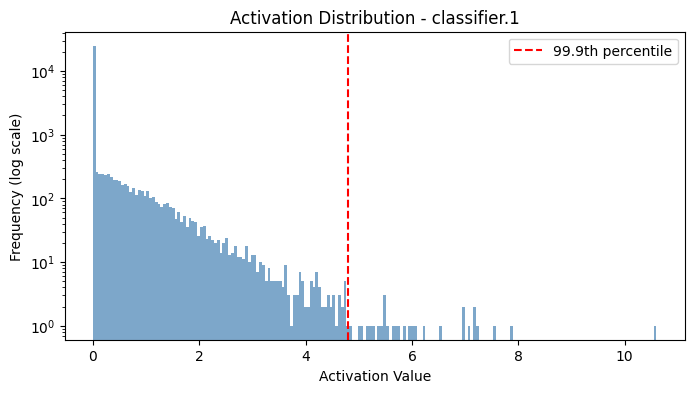

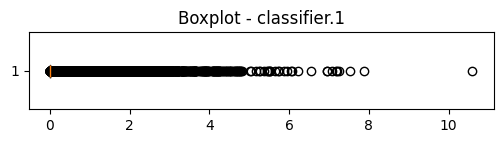

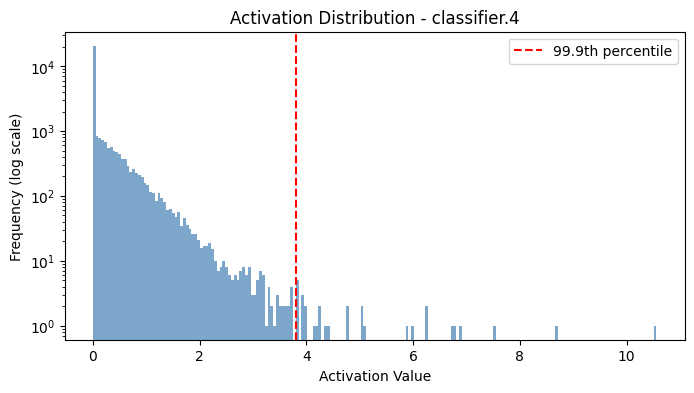

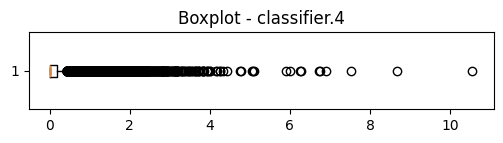

In [28]:
def plot_activation_histograms(activations, layers_to_show, bins=200):
    for name in layers_to_show:
        data = activations[name].numpy()
        plt.figure(figsize=(8, 4))
        plt.hist(data, bins=bins, log=True, color='steelblue', alpha=0.7)
        plt.title(f"Activation Distribution - {name}")
        plt.xlabel("Activation Value")
        plt.ylabel("Frequency (log scale)")
        plt.axvline(np.percentile(data, 99.9), color='red', linestyle='--', label='99.9th percentile')
        plt.legend()
        plt.show()

        # Boxplot for outlier visualization
        plt.figure(figsize=(6, 1))
        plt.boxplot(data, vert=False, showfliers=True)
        plt.title(f"Boxplot - {name}")
        plt.show()

plot_activation_histograms(activations, list(activations.keys())[-5:])


In [69]:
class QuantizedLinearINT8(nn.Module):
    """
    True INT8 quantized Linear layer with optional percentile-based clipping
    for both weights and activations.
    """
    def __init__(self, linear_module, bits=8, percentile=None):
        super().__init__()
        self.in_features = linear_module.in_features
        self.out_features = linear_module.out_features
        self.bits = bits
        self.percentile = percentile

        # Quantize weights
        q_w, scale_w = self.quantize_tensor(linear_module.weight, bits, percentile)
        self.register_buffer("weight_q", q_w.to(torch.int8))
        self.register_buffer("scale_w", torch.tensor(scale_w, dtype=torch.float32))

        # Store bias (float)
        if linear_module.bias is not None:
            self.register_buffer("bias", linear_module.bias.detach().clone())
        else:
            self.bias = None

    def quantize_tensor(self, tensor, bits, percentile=None):
        qmin, qmax = -(2**(bits-1)), 2**(bits-1) - 1
        tensor_cpu = tensor.detach().cpu()

        # Percentile clipping
        if percentile is not None:
            clip_val = np.percentile(tensor_cpu.abs().numpy(), percentile)
            tensor_cpu = torch.clamp(tensor_cpu, -clip_val, clip_val)
        else:
            clip_val = tensor_cpu.abs().max().item()

        clip_val = max(clip_val, 1e-8)
        scale = clip_val / qmax
        q = torch.clamp((tensor_cpu / scale).round(), qmin, qmax)
        return q, scale

    def quantize_activation(self, x):
        """
        Apply percentile clipping to activations as well.
        """
        x_cpu = x.detach().cpu()
        if self.percentile is not None:
            clip_val = np.percentile(x_cpu.abs().numpy(), self.percentile)
            x_clipped = torch.clamp(x_cpu, -clip_val, clip_val)
        else:
            clip_val = x_cpu.abs().max().item()
            x_clipped = x_cpu

        clip_val = max(clip_val, 1e-8)
        scale = clip_val / 127
        q = torch.clamp((x_clipped / scale).round(), -128, 127)
        return q.to(torch.int8).to(x.device), scale

    def forward(self, x):
        # Quantize activations with percentile-based clipping
        x_q, x_scale = self.quantize_activation(x)

        # Integer matmul (int8 × int8 → int32)
        out_int32 = torch.matmul(
            x_q.to(torch.int32),
            self.weight_q.T.to(torch.int32)
        )

        # Dequantize
        out = out_int32.to(torch.float32) * (x_scale * self.scale_w)

        if self.bias is not None:
            out += self.bias

        return out


In [43]:
def convert_model_to_int8(model, bits=8, percentile=None):
    model_q = deepcopy(model)
    for name, module in model_q.named_children():
        if isinstance(module, nn.Linear):
            setattr(model_q, name, QuantizedLinearINT8(module, bits=bits, percentile=percentile))
        else:
            setattr(model_q, name, convert_model_to_int8(module, bits, percentile))
    return model_q

In [ ]:
# def quantize_tensor_int8(tensor, bits=8, percentile=None, symmetric=True):
#     qmin, qmax = -(2**(bits-1)), 2**(bits-1) - 1
    
#     tensor_cpu = tensor.detach().cpu()
#     if percentile is not None:
#         # Apply clipping based on percentile
#         clip_val = np.percentile(tensor_cpu.abs().numpy(), percentile)
#         tensor_cpu = torch.clamp(tensor_cpu, -clip_val, clip_val)
#     else:
#         clip_val = tensor_cpu.abs().max().item()
    
#     scale = clip_val / qmax if clip_val > 0 else 1.0
#     q = torch.clamp((tensor_cpu / scale).round(), qmin, qmax).to(torch.int8)
#     return q, scale


# def quantize_linear_layers_int8(model, bits=8, percentile=None):
#     model_q = deepcopy(model)
#     for name, module in model_q.named_modules():
#         if isinstance(module, nn.Linear):
#             with torch.no_grad():
#                 # Quantize weights
#                 q_w, scale_w = quantize_tensor_int8(module.weight, bits, percentile)
#                 module.weight = nn.Parameter(q_w.float() * scale_w)  # dequantized for forward use
                
#                 # Quantize bias if present
#                 if module.bias is not None:
#                     q_b, scale_b = quantize_tensor_int8(module.bias, bits, percentile)
#                     module.bias = nn.Parameter(q_b.float() * scale_b)
#     return model_q


In [70]:
# Clipped INT8 quantization (99.9 percentile)
model_q_clipped = convert_model_to_int8(model, bits=8, percentile=99.9)

In [71]:
acc_clipped = evaluate(model_q_clipped, test_loader, device)
print(f"Clipped (99.9%) INT8 quantization: {acc_clipped:.2f}%")

  0%|          | 0/79 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 79/79 [01:10<00:00,  1.13it/s]

Clipped (99.9%) INT8 quantization: 71.16%


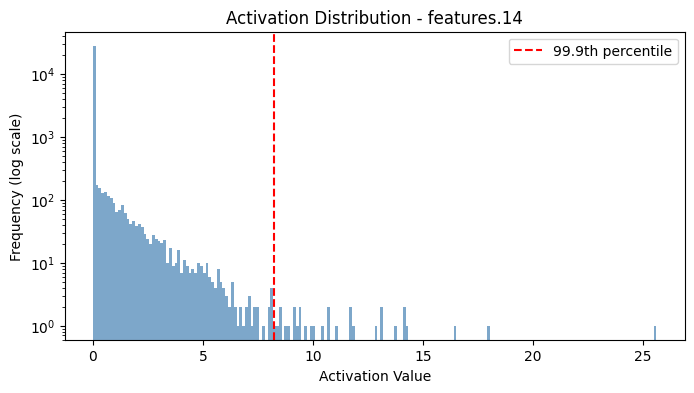

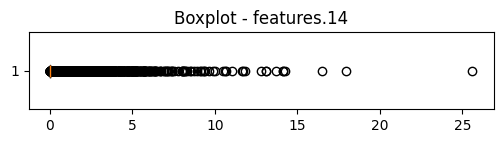

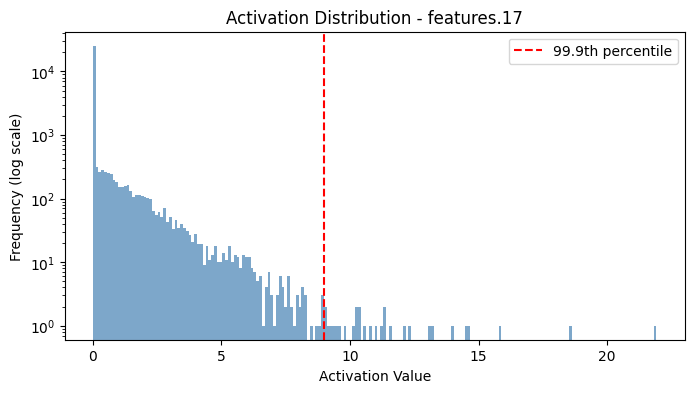

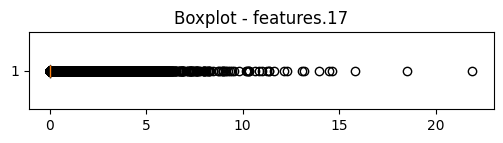

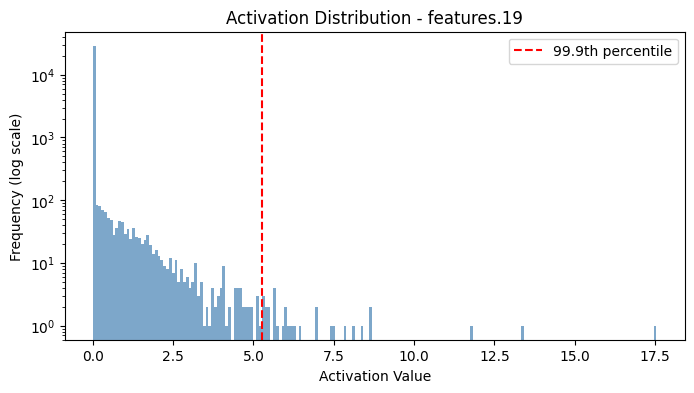

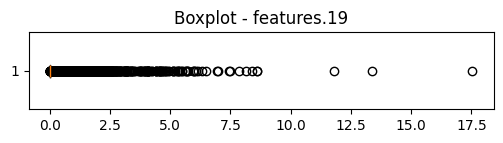

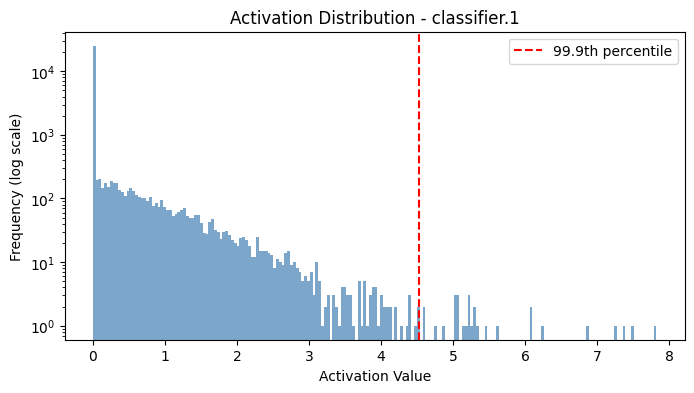

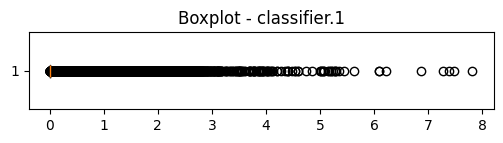

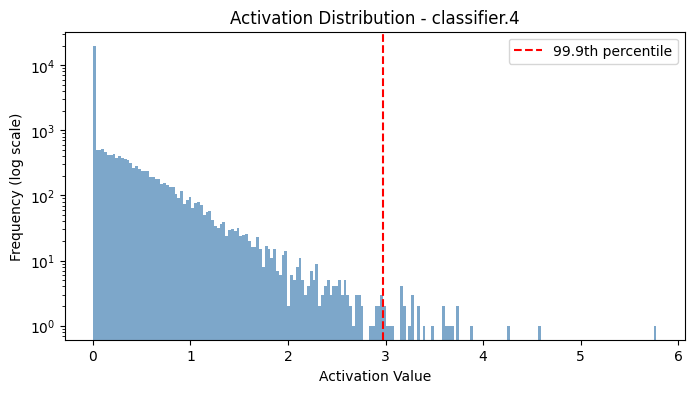

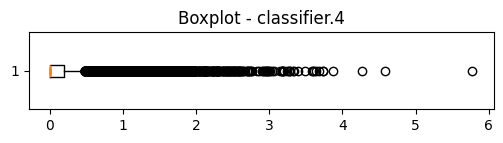

In [72]:
activations_clip = collect_activations(model_q_clipped, test_loader, device)
plot_activation_histograms(activations_clip, list(activations_clip.keys())[-5:])